### Set GPU clocks

In [ ]:
!sudo nvidia-persistenced
!sudo nvidia-smi -ac 877,1530

In [1]:
from core import *
from torch_backend import *

### Network definition

In [2]:
def conv_bn(c_in, c_out):
    return {
        'conv': nn.Conv2d(c_in, c_out, kernel_size=3, stride=1, padding=1, bias=False), 
        'bn': BatchNorm(c_out), 
        'relu': nn.ReLU(True)
    }

def residual(c):
    return {
        'in': Identity(),
        'res1': conv_bn(c, c),
        'res2': conv_bn(c, c),
        'add': (Add(), ['in', 'res2/relu']),
    }

def net(channels=None, weight=0.125, pool=nn.MaxPool2d(2), extra_layers=(), res_layers=('layer1', 'layer3')):
    channels = channels or {'prep': 64, 'layer1': 128, 'layer2': 256, 'layer3': 512}
    n = {
        'input': (None, []),
        'prep': conv_bn(3, channels['prep']),
        'layer1': dict(conv_bn(channels['prep'], channels['layer1']), pool=pool),
        'layer2': dict(conv_bn(channels['layer1'], channels['layer2']), pool=pool),
        'layer3': dict(conv_bn(channels['layer2'], channels['layer3']), pool=pool),
        'pool': nn.MaxPool2d(4),
        'flatten': Flatten(),
        'linear': nn.Linear(channels['layer3'], 10, bias=False),
        'logits': Mul(weight),
    }
    for layer in res_layers:
        n[layer]['residual'] = residual(channels[layer])
    for layer in extra_layers:
        n[layer]['extra'] = conv_bn(channels[layer], channels[layer])       
    return n

### Download and preprocess data

In [3]:
DATA_DIR = './data'
dataset = cifar10(root=DATA_DIR)
timer = Timer()
print('Preprocessing training data')
transforms = [
    partial(normalise, mean=np.array(cifar10_mean, dtype=np.float32), std=np.array(cifar10_std, dtype=np.float32)),
    partial(transpose, source='NHWC', target='NCHW'), 
]
train_set = list(zip(*preprocess(dataset['train'], [partial(pad, border=4)] + transforms).values()))
print(f'Finished in {timer():.2} seconds')
print('Preprocessing test data')
valid_set = list(zip(*preprocess(dataset['valid'], transforms).values()))
print(f'Finished in {timer():.2} seconds')

Files already downloaded and verified
Files already downloaded and verified
Preprocessing training data
Finished in 2.9 seconds
Preprocessing test data
Finished in 0.15 seconds


### Network visualisation

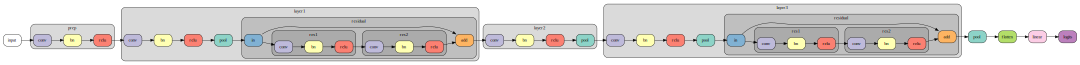

In [3]:
colors = ColorMap()
draw = lambda graph: DotGraph({p: ({'fillcolor': colors[type(v)], 'tooltip': repr(v)}, inputs) for p, (v, inputs) in graph.items() if v is not None})

draw(build_graph(net()))

### Training

NB: on the first run, the first epoch will be slower as initialisation and Cudnn benchmarking take place.

In [ ]:
epochs=24
lr_schedule = PiecewiseLinear([0, 5, epochs], [0, 0.4, 0])
batch_size = 512
train_transforms = [Crop(32, 32), FlipLR(), Cutout(8, 8)]
N_runs = 3

train_batches = DataLoader(Transform(train_set, train_transforms), batch_size, shuffle=True, set_random_choices=True, drop_last=True)
valid_batches = DataLoader(valid_set, batch_size, shuffle=False, drop_last=False)
lr = lambda step: lr_schedule(step/len(train_batches))/batch_size

summaries = []
for i in range(N_runs):
    print(f'Starting Run {i} at {localtime()}')
    model = Network(net()).to(device).half()
    opts = [SGD(trainable_params(model).values(), {'lr': lr, 'weight_decay': Const(5e-4*batch_size), 'momentum': Const(0.9)})]
    logs, state = Table(), {MODEL: model, LOSS: x_ent_loss, OPTS: opts}
    for epoch in range(epochs):
        logs.append(union({'epoch': epoch+1}, train_epoch(state, Timer(torch.cuda.synchronize), train_batches, valid_batches)))
logs.df().query(f'epoch=={epochs}')[['train_acc', 'valid_acc']].describe()

Starting Run 0 at 2018-12-04 16:36:29
       epoch           lr   train time   train loss    train acc    test time    test loss     test acc   total time
           1       0.0800       4.2188       1.6095       0.4167       0.4228       1.4103       0.5157       4.6416
           2       0.1600       2.9172       0.9291       0.6712       0.2854       0.8575       0.7107       7.8441
           3       0.2400       2.9170       0.7249       0.7455       0.2260       0.8204       0.7263      10.9871
           4       0.3200       2.9177       0.6237       0.7836       0.2259       0.6574       0.7718      14.1306
           5       0.4000       2.9189       0.5514       0.8089       0.2262       0.7334       0.7503      17.2757
           6       0.3789       2.9205       0.4934       0.8316       0.2262       0.6091       0.7845      20.4224
           7       0.3579       2.9619       0.4416       0.8492       0.2261       0.4791       0.8369      23.6104
           8       0.3368 